#전이 학습(Transfer Learning)을 활용한 엽채류 분류기 인공지능 서비스 개발

###프로젝트 목표
- 스마트팜에서 재배하는 대표적인 엽채류 로메인, 케일, 루꼴라를 분류하는 AI 서비스 개발

- 자동화 프로그램으로 각각의 이미지를 수집한 뒤에 ResNet 전이힉습 모델을 이용하여 학습한 모델을 웹 API로 배포

- 실제 AI 서비스 개발 과정을 실습하며 AI 응용 서비스 개발자의 역량 강화


---


일반적인 AI 서비스 개발은 데이터의 수집과 가공, 모델 학습, API 배포 과정으로 진행된다  
본 프로젝트에서는 아래 개발 과정을 거쳐서 상용가능한 AI 서비스를 제작하려고 한다  
    1. 이미지 크롤링(image crawling) 혹은 크롤링 라이브러리  
    2. 전이 학습(transfer learning)  
    3. 웹 API 개발  

AI 서비스는 스마트팜의 대표 엽채류 작물인 <b>로메인, 케일, 루꼴라</b>  분류기 (classifier)제작을 목표로 함

In [1]:
# 한글 폰트 설치
!apt install fonts-nanum -y
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=10)
plt.rc('font', family='NanumBarunGothic')
matplotlib.font_manager._rebuild()

# 이미지 크롤링에 필요한 라이브러리
!git clone https://github.com/ndb796/bing_image_downloader # 이미지 다운로더
from bing_image_downloader.bing_image_downloader import downloader
import os
import shutil # 파일 작업

# 학습을 위한 라이브러리 설치
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
import numpy as np
import time

# GPU를 활용하여 학습진행을 하기때문에 CUDA에 최적화된 모델로 변환
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 

# API 배포에 필요한 라이브러리 설치
!pip install flask-ngrok 
from PIL import Image
import io
from flask_ngrok import run_with_ngrok
from flask import Flask, jsonify, request

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 5 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#### <b>1. 이미지 크롤링을 활용한 학습 이미지 수집</b>

수집한 이미지를 저장하기 위한 폴더 생성과 필요한 함수 정의  
ImageFolder 라이브러리 이용을 위해 학습데이터와 테스트데이터가 클래스별로 담기게 구성하였다


In [3]:
# 학습 데이터와 테스트 데이터를 구분하여 폴더 생성
directory_list = [
    './dataset/train/',
    './dataset/test/']

# 디렉토리 생성
for directory in directory_list:
    if not os.path.isdir(directory):
        os.makedirs(directory)

def dataset_split(query, train_cnt):# 수집한 이미지를 학습과 테스트 데이터 구분하여 입력
    # 데이터셋 디렉토리 생성
    for directory in directory_list:
        if not os.path.isdir(directory + '/' + query):
            os.makedirs(directory + '/' + query)
    # 데이터셋 추가
    cnt = 0
    for file_name in os.listdir(query):
        if cnt < train_cnt:
            print(f'[Train Dataset] {file_name}')
            shutil.move(query + '/' + file_name, './dataset/train/' + query + '/' + file_name)
        else:
            print(f'[Test Dataset] {file_name}')
            shutil.move(query + '/' + file_name, './dataset/test/' + query + '/' + file_name)
        cnt += 1
    shutil.rmtree(query) #query 트리 삭제

각각의 이미지 크롤링을 진행하여 데이터셋 입력  
50개 이미지를 크롤링하고 앞서 정의한 dataset_split()로 30개는 학습, 나머지는 테스트 데이터 저장경로로 이동

In [4]:
query = '로메인'
downloader.download(query, limit=50,  output_dir='./', adult_filter_off=True, force_replace=False, timeout=60)
dataset_split(query,30)

[Info] Indexing page: 1
[Info] Indexed 35 Images on Page 1.
#1 이미지 다운로드 (https://newsimg.hankookilbo.com/cms/articlerelease/2018/11/21/201811211562083387_1.jpg)
#1 파일 다운로드가 완료되었습니다.
#2 이미지 다운로드 (https://contents.sixshop.com/uploadedFiles/10735/product/image_1529486902373.png)
#2 파일 다운로드가 완료되었습니다.
#3 이미지 다운로드 (https://cdnweb01.wikitree.co.kr/webdata/editor/201811/22/img_20181122144022_441c6598.jpg)
#3 파일 다운로드가 완료되었습니다.
#4 이미지 다운로드 (https://t1.daumcdn.net/cfile/tistory/2659C240589483592D)
#4 파일 다운로드가 완료되었습니다.
#5 이미지 다운로드 (https://img1.daumcdn.net/thumb/R800x0/?scode=mtistory2&amp;fname=http:%2F%2Fcfs7.blog.daum.net%2Fupload_control%2Fdownload.blog%3Ffhandle%3DMEdsSWFAZnM3LmJsb2cuZGF1bS5uZXQ6L0lNQUdFLzAvODIuanBn%26filename%3D82.jpg)
[Info] Issue getting: https://img1.daumcdn.net/thumb/R800x0/?scode=mtistory2&amp;fname=http:%2F%2Fcfs7.blog.daum.net%2Fupload_control%2Fdownload.blog%3Ffhandle%3DMEdsSWFAZnM3LmJsb2cuZGF1bS5uZXQ6L0lNQUdFLzAvODIuanBn%26filename%3D82.jpg
[Error] HTTP Error 403: F

In [5]:
query = '케일'
downloader.download(query, limit=50,  output_dir='./', adult_filter_off=True, force_replace=False, timeout=60)
dataset_split(query,30)

[Info] Indexing page: 1
[Info] Indexed 35 Images on Page 1.
#1 이미지 다운로드 (https://t1.daumcdn.net/cfile/tistory/99FA8F415B16276A25)
#1 파일 다운로드가 완료되었습니다.
#2 이미지 다운로드 (https://t1.daumcdn.net/cfile/tistory/99C459425B16276D2D)
#2 파일 다운로드가 완료되었습니다.
#3 이미지 다운로드 (http://gdimg.gmarket.co.kr/1184746427/still/600?ver=1523507647)
#3 파일 다운로드가 완료되었습니다.
#4 이미지 다운로드 (https://t1.daumcdn.net/cfile/tistory/9961B2375B16276902)
#4 파일 다운로드가 완료되었습니다.
#5 이미지 다운로드 (https://blog.kakaocdn.net/dn/caQXsd/btqCZZSdp9c/xYsgednaVKytu99bqd32qK/img.jpg)
#5 파일 다운로드가 완료되었습니다.
#6 이미지 다운로드 (https://t1.daumcdn.net/cfile/tistory/2471455058B7EC5435)
#6 파일 다운로드가 완료되었습니다.
#7 이미지 다운로드 (https://t1.daumcdn.net/thumb/R1280x0/?fname=http://t1.daumcdn.net/brunch/service/user/2fp6/image/EmwUh0JebQ_k-WIQ8PdX9uNNaWo.JPG)
#7 파일 다운로드가 완료되었습니다.
#8 이미지 다운로드 (https://image.fnnews.com/resource/media/image/2020/11/27/202011271752305394_l.jpg)
#8 파일 다운로드가 완료되었습니다.
#9 이미지 다운로드 (http://recipe1.ezmember.co.kr/cache/recipe/2017/06/18/2e637bc85cde8c87

In [6]:
query = '루꼴라'
downloader.download(query, limit=50,  output_dir='./', adult_filter_off=True, force_replace=False, timeout=60)
dataset_split(query,30)

[Info] Indexing page: 1
[Info] Indexed 35 Images on Page 1.
#1 이미지 다운로드 (http://image.auction.co.kr/itemimage/f3/c7/fd/f3c7fd516.jpg)
#1 파일 다운로드가 완료되었습니다.
#2 이미지 다운로드 (http://www.xplant.co.kr/data/item/14947/1494711488_l4)
#2 파일 다운로드가 완료되었습니다.
#3 이미지 다운로드 (https://t1.daumcdn.net/cfile/tistory/9922543359B9CAFD45)
#3 파일 다운로드가 완료되었습니다.
#4 이미지 다운로드 (https://image2.xplant.co.kr/data/item/14947/1494711488_l3.jpg)
#4 파일 다운로드가 완료되었습니다.
#5 이미지 다운로드 (https://image2.xplant.co.kr/data/item/14947/1494711488_l5.jpg)
#5 파일 다운로드가 완료되었습니다.
#6 이미지 다운로드 (https://cureviews.kr/wp-content/uploads/2021/04/main_img_1-6070.jpg)
#6 파일 다운로드가 완료되었습니다.
#7 이미지 다운로드 (http://www.myplant.co.kr/shopimages/myplant/0070040000713.jpg?1573188021)
#7 파일 다운로드가 완료되었습니다.
#8 이미지 다운로드 (https://hgarden.net/wp-content/uploads/2020/09/Rhaphidophora-600-400x269.jpg)
#8 파일 다운로드가 완료되었습니다.
#9 이미지 다운로드 (https://whatieat.co.kr/wp-content/uploads/2018/06/GX5C2428.jpg)
#9 파일 다운로드가 완료되었습니다.
#10 이미지 다운로드 (https://image.homeplus.kr/td/064571b

#### 2. ResNet을 이용한 전이 학습(Transfer Learning)


In [7]:
# pytorch tensor에 적합하게 데이터 증가(augmentation) 및 일반화(normalization)
transforms_train = transforms.Compose([
    transforms.Resize((224, 224)), # 해상도 통일
    transforms.RandomHorizontalFlip(), # 랜덤으로 좌우 반전
    transforms.RandomRotation(20),# 랜덤으로 20도 내에서 회전 
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalization
])

transforms_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
# 각각의 학습, 테스트 데이터를 부른 뒤에 전체 데이터를 학습하는 과정에서 dataloader를 이용해 batch_size만큼 데이터를 모델에 입력
data_dir = './dataset' 
train_datasets = datasets.ImageFolder(os.path.join(data_dir, 'train'), transforms_train)
test_datasets = datasets.ImageFolder(os.path.join(data_dir, 'test'), transforms_test)

train_dataloader = torch.utils.data.DataLoader(train_datasets, batch_size=4, shuffle=True, num_workers=4)
test_dataloader = torch.utils.data.DataLoader(test_datasets, batch_size=4, shuffle=True, num_workers=4)

print('train datasets 크기:', len(train_datasets))
print('test datasets 크기:', len(test_datasets))

print(train_datasets.classes)# 분류할 클래스

train datasets 크기: 101
test datasets 크기: 67
['로메인', '루꼴라', '케일']


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


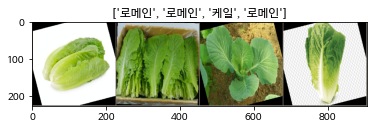

In [8]:
def imshow(input, title):
    # torch.Tensor를 numpy 객체로 변환하여 matplotlib 라이브러리가 사용 가능하도록 처리
    input = input.numpy().transpose((1, 2, 0)) # Pytorch는 배치, 채널, 높이, 너비 순으로 데이터가 구성되어야
    # 이미지 정규화 해제
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    input = std * input + mean
    input = np.clip(input, 0, 1)
    
    plt.imshow(input)
    plt.title(title)
    plt.show()

# 학습 데이터 설정한 배치 사이즈만큼 불러와 시각화
iterator = iter(train_dataloader)
inputs, classes = next(iterator)
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[train_datasets.classes[x] for x in classes])


Torch에서 제공하는 resnet34모델을 불러와 전이학습   
마지막 출력 뉴런을 3개로 변환 처리하여 학습 수행

In [9]:
base_model = models.resnet34(pretrained=True)
num_features = base_model.fc.in_features

base_model.fc = nn.Linear(num_features, 3) # 출력 뉴런 수 변환하여 마지막 레이어 재학습
model = base_model.to(device) # 학습하는 모델 초기화

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(base_model.parameters(), lr=0.001, momentum=0.9)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



학습 데이터로 모델 학습 진행

In [10]:
num_epochs = 50
model.train()# 모델을 학습 모드로 설정
start_time = time.time()
for epoch in range(num_epochs):
    running_loss = 0.
    running_corrects = 0

    for inputs, labels in train_dataloader: # 학습 데이터 호출 
        inputs = inputs.to(device)
        labels = labels.to(device)

        # 모델에 입력하고 결과 계산하는 과정
        optimizer.zero_grad()# 입력값을 넣기 전에 매개변수 경사도를 0으로 초기화
        # 순전파 / 연산 기록 추적
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels) # CrossEntropyLoss로 정답과 출력이 유사한 방향으로 모델 업데이트

        loss.backward() # 역전파 수행
        optimizer.step() # optimizer로 구해진 기울기(gradient)업데이트

        # 통계
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_datasets)
    epoch_acc = running_corrects / len(train_datasets) * 100.

    print(f'{epoch} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f},Time: { time.time() - start_time:.4f}s')

0 Loss: 1.0623 Acc: 49.5050,Time: 4.0875s
1 Loss: 0.6196 Acc: 74.2574,Time: 6.3871s
2 Loss: 0.3306 Acc: 87.1287,Time: 8.6542s
3 Loss: 0.4621 Acc: 86.1386,Time: 11.0110s
4 Loss: 0.4505 Acc: 81.1881,Time: 13.3098s
5 Loss: 0.6016 Acc: 79.2079,Time: 15.5601s
6 Loss: 0.3998 Acc: 88.1188,Time: 17.9030s
7 Loss: 0.6197 Acc: 78.2178,Time: 20.2228s
8 Loss: 0.6191 Acc: 80.1980,Time: 22.5122s
9 Loss: 0.2782 Acc: 90.0990,Time: 24.8784s
10 Loss: 0.2701 Acc: 93.0693,Time: 27.2340s
11 Loss: 0.2864 Acc: 90.0990,Time: 29.5834s
12 Loss: 0.2051 Acc: 91.0891,Time: 31.8753s
13 Loss: 0.3017 Acc: 88.1188,Time: 34.2453s
14 Loss: 0.7106 Acc: 80.1980,Time: 36.5561s
15 Loss: 0.2973 Acc: 92.0792,Time: 38.8994s
16 Loss: 0.2576 Acc: 89.1089,Time: 41.2043s
17 Loss: 0.4368 Acc: 85.1485,Time: 44.5954s
18 Loss: 0.2375 Acc: 94.0594,Time: 48.1247s
19 Loss: 0.1991 Acc: 92.0792,Time: 51.0836s
20 Loss: 0.1699 Acc: 93.0693,Time: 53.3893s
21 Loss: 0.3725 Acc: 91.0891,Time: 55.7079s
22 Loss: 0.2989 Acc: 89.1089,Time: 58.0233s
2

테스트 데이터에 모델을 적용하여 학습 모델의 성능 평가  
모델 예측값 시각화하여 구현  

[예측: 루꼴라] (정답: 루꼴라)


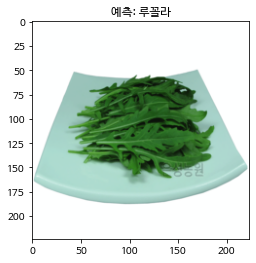

[예측: 로메인] (정답: 로메인)


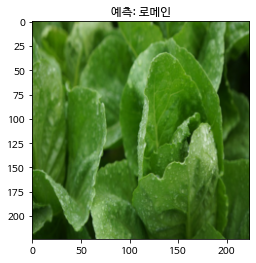

[예측: 루꼴라] (정답: 루꼴라)


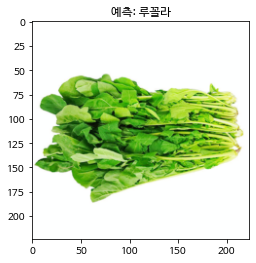

[예측: 루꼴라] (정답: 루꼴라)


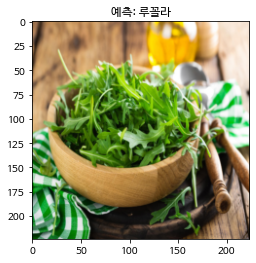

[예측: 케일] (정답: 케일)


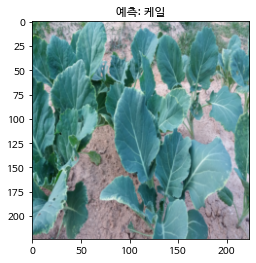

[예측: 로메인] (정답: 로메인)


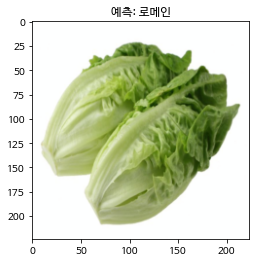

[예측: 루꼴라] (정답: 루꼴라)


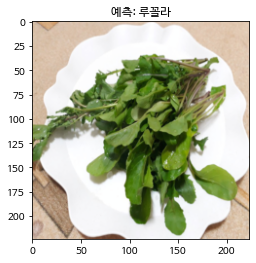

[예측: 로메인] (정답: 로메인)


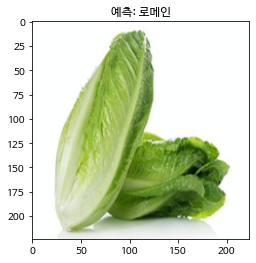

[예측: 케일] (정답: 케일)


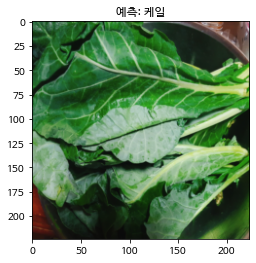

[예측: 로메인] (정답: 로메인)


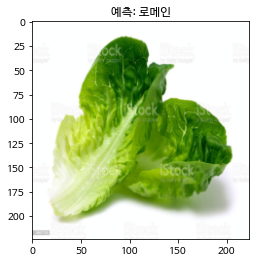

[예측: 로메인] (정답: 로메인)


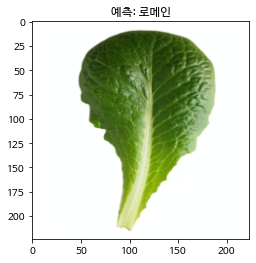

[예측: 케일] (정답: 케일)


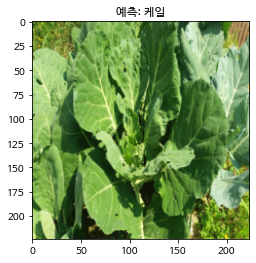

[예측: 케일] (정답: 케일)


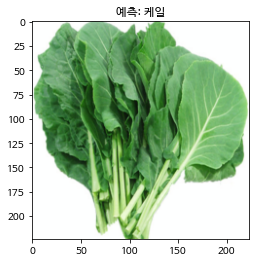

[예측: 로메인] (정답: 로메인)


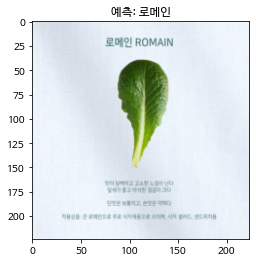

[예측: 루꼴라] (정답: 루꼴라)


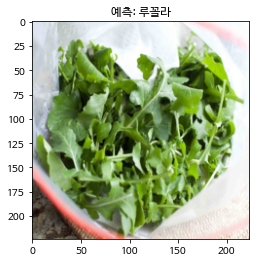

[예측: 루꼴라] (정답: 루꼴라)


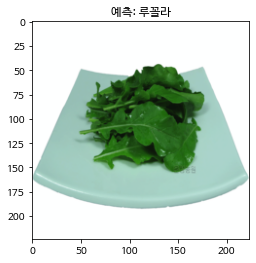

[예측: 케일] (정답: 케일)


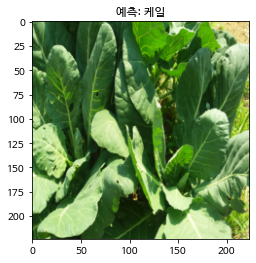

[Test Phase] Loss: 0.0454 Acc: 100.0000% Time: 4.7412s


In [11]:
model.eval() # 테스트 모드로 설정
start_time = time.time()
class_names = train_datasets.classes

with torch.no_grad():
    running_loss = 0.
    running_corrects = 0

    for inputs, labels in test_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        # 매 배치마다 인덱스 0번 이미지만 비교 후 출력
        print(f'[예측: {class_names[preds[0]]}] (정답: {class_names[labels.data[0]]})')
        imshow(inputs.cpu().data[0], title='예측: ' + class_names[preds[0]])

    epoch_loss = running_loss / len(test_datasets)
    epoch_acc = running_corrects / len(test_datasets) * 100.
    print('[Test Phase] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch_loss, epoch_acc, time.time() - start_time))

#### <b>3. 분류 모델 API 개발</b>

학습된 분류 모델을 다른 프로그램이 사용할 수 있도록 API를 개발하여 배포  

소유한 공인 IP가 없으므로 Ngrok 서비스를 이용하여 별도 공인 주소를 할당 받아 서버를 외부에 개방하는 방식으로 선택하였고   
API 기능 제공은 Flask 프레임워크를 사용하였다

In [12]:
# 테스트용 위키피디아 케일 이미지 다운로드
# !wget https://commons.wikimedia.org/wiki/File:Boerenkool.jpg -O test_image.jpg
!wget https://upload.wikimedia.org/wikipedia/commons/thumb/2/20/Boerenkool.jpg/330px-Boerenkool.jpg -O test_image.jpg

--2022-11-16 12:20:17--  https://upload.wikimedia.org/wikipedia/commons/thumb/2/20/Boerenkool.jpg/330px-Boerenkool.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 198.35.26.112, 2620:0:863:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|198.35.26.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 62507 (61K) [image/jpeg]
Saving to: ‘test_image.jpg’

test_image.jpg      100%[===================>]  61.04K  --.-KB/s    in 0.03s   

2022-11-16 12:20:17 (2.01 MB/s) - ‘test_image.jpg’ saved [62507/62507]



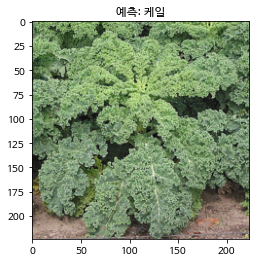

In [13]:
image = Image.open('/content/test_image.jpg')
image = transforms_test(image).unsqueeze(0).to(device) # 이미지를 tensor형태로 변경

with torch.no_grad():
    outputs = model(image)
    _, preds = torch.max(outputs, 1)
    imshow(image.cpu().data[0], title='예측: ' + class_names[preds[0]])

특정 클라이언트로부터이미지 입력 파일을 전달 받아 모델 실행 결과를 출력하는 형태로 API 함수 생성

In [14]:
def get_prediction(image_bytes):
    image = Image.open(io.BytesIO(image_bytes))
    image = transforms_test(image).unsqueeze(0).to(device)# Pytorch의 텐서에 맞게 변형

    with torch.no_grad():
        outputs = model(image)
        _, preds = torch.max(outputs, 1)
        imshow(image.cpu().data[0], title='예측: ' + class_names[preds[0]])
    return class_names[preds[0]]

app = Flask(__name__)# Flask 어플리케이션 객체 초기화

@app.route('/', methods=['POST'])# 반드시 데코레이터가 가르키는 주소에 접근했을 때 반환해줄 함수위에 정의
def predict():
    if request.method == 'POST':# POST방식으로 루트경로에 파일이 도착하면 
        file = request.files['file']# 이미지 바이트 데이터 받아오기
        image_bytes = file.read()

        class_name = get_prediction(image_bytes=image_bytes)# 분류 결과 확인 및 클라이언트에게 결과 반환
        print("결과:", {'class_name': class_name})
        return jsonify({'class_name': class_name})

이제 Colab에 Ngrok서비스를 연결되어 API 개방 가능하다  
주의할 점은 무료 서비스이기에 실행할 때마다 서버 주소가 변경되고 시간적 제약 존재하며
배포자의 경우 미리 Ngrok이 설치되어 있어야 한다  


코드들 실행하면 생성된 주소에 하나의 이미지 파일을 주면  Flask 서버에 입력으로 들어가 
서버로 부터 분류 결과 출력된다  

In [17]:
run_with_ngrok(app)
app.run()

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


INFO:werkzeug: * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://40ce-35-197-102-166.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040
 * Running on http://40ce-35-197-102-166.ngrok.io * Running on http://40ce-35-197-102-166.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040

 * Traffic stats available on http://127.0.0.1:4040


INFO:werkzeug:127.0.0.1 - - [16/Nov/2022 12:53:06] "GET / HTTP/1.1" 405 -
INFO:werkzeug:127.0.0.1 - - [16/Nov/2022 12:53:07] "GET /favicon.ico HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [16/Nov/2022 12:53:09] "GET / HTTP/1.1" 405 -


클라이언트에서는 명령 프롬프트에 아래 명령으로 테스트할 수 있다

<pre>
curl -X POST -F file=@{파일명} {Ngrok 서버 주소}
</pre>


###결언
본 프로젝트를 통해 인공지능 서비스의 개발 과정 과  API 배포 시스템의 흐름을 이해할 수 있었다.  
글로 배포와 API의 개념은 익혔지만 막연하게 느껴지는 부분이 있어 아쉬웠었다.   
실제로  모델을 배포하면서 생각보다 많은 요소가 고려되어야 하고 결과적으론  시스템의 구성을 알고 활용하는 능력이 중요하다고 느꼈다.   
어떤 코드도 결국은 서비스를 제공하기 위해 개발되는데 전체적인 시각으로 보는 역량을 기르면 효율적인 코딩이나 서비스 제공에 좋은 성과를 기대해볼 수 있을 것 같다.  


참고  
https://tutorials.pytorch.kr/beginner/transfer_learning_tutorial.html  
https://velog.io/@dldydldy75/series/%EB%82%98%EB%A7%8C%EC%9D%98-%EB%8D%B0%EC%9D%B4%ED%84%B0%EC%85%8B%EC%9C%BC%EB%A1%9C-%EC%9D%B4%EB%AF%B8%EC%A7%80-%EB%B6%84%EB%A5%98%ED%95%98%EA%B8%B0  
https://scribblinganything.tistory.com/119  
https://tlog.tammolo.com/posts/ngrok-localtunnel  
https://mong9data.tistory.com/145  

